# B455 Project 5
By Owen Gordon
<br><br>

For this project we were trying to predict the chance of admittance to graduate school for Indian students. The dataset we used contains 500 samples, each with 7 features. These features are: 1. GRE Scores (out of 340) 2. TOEFL Scores (out of 120) 3. University Rating (out of 5) 4. Statement of Purpose 5. Letter of Recommendation Strength (out of 5) 6. Undergraduate GPA (out of 10) 7. Research Experience (either 0 or 1). The dependent variable here is the chance of admittance, which ranges from 0 to 1 corresponding to 0% chance to 100%. <br><br>

I decided to implement 5 different machine learning algorithms to perform regression on this data. The first algorithm I chose was the Ridge regression method. This algorithm is a modifided linear regression algorithm that introduces introduces a penalty to optimze the linear regression technique. The second algorithm was a support vector machine performing regression. Similar to a normal support vector machine, except that this algorithm performs regression. The third algorithm is an MLP also performing regression. This algorithm has all the same hyper-parameters as a MLP classifier. The fourth algorithm is random forest regression. Again, this is the same as the random forest algorithm for classification, only with the output being regression. The final algorithm I chose to use was KNN regression. Just like the other algorithms, this approach is the same as the classification method, but solving regression instead. <br><br>

I used the corresponding sklearn packages to implement each of these algorithms.

In [1]:
# import everything needed to get started
import numpy as np
import pandas as pd

from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

The first step before regression can be completed is loading the dataset. I used pandas DataFrames to contain the data, and the read_csv method to load the data in. <br><br>

Note: the data I used was in the same directory as this notebook file, and titled 'Admission_Predict_Ver1.1.csv'. If this is not the case, the path in the read_csv function call must be updated

In [2]:
# load dataset

df = pd.read_csv('Admission_Predict_Ver1.1.csv', index_col=[0])
df

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
Serial No.,,,,,,,,
1,337,118,4,4.5,4.5,9.65,1,0.92
2,324,107,4,4.0,4.5,8.87,1,0.76
3,316,104,3,3.0,3.5,8.00,1,0.72
4,322,110,3,3.5,2.5,8.67,1,0.80
5,314,103,2,2.0,3.0,8.21,0,0.65
...,...,...,...,...,...,...,...,...
496,332,108,5,4.5,4.0,9.02,1,0.87
497,337,117,5,5.0,5.0,9.87,1,0.96
498,330,120,5,4.5,5.0,9.56,1,0.93


For comparing performance I am going to use five-fold cross validation. This is the technique of using 1/5th of the data as validation data, and then incrementing over all 5 different subsets to gain an averaged score. This method will act as the primary testing method for measuring the performance of these different ML algorithms.

In [3]:
def five_fold_cross_val(inputs, targets, clf):
    def five_fold(inputs, targets):
        D_inputs = []
        D_targets = []
        D_dict = {'d1': [], 'd2': [], 'd3': [], 'd4': [], 'd5': []}
        D_target_dict = {'d1': [], 'd2': [], 'd3': [], 'd4': [], 'd5': []}

        for x in range(len(inputs)):
            D_dict['d' + str((x % 5) + 1)].append(inputs[x])
            D_target_dict['d' + str((x % 5) + 1)].append(targets[x])
        for k in D_dict.keys():
            D_inputs.append(np.array(D_dict[k]))
            D_targets.append(np.array(D_target_dict[k]))
        return D_inputs, D_targets

    D, t = five_fold(inputs, targets)

    scores = []
    for i in range(len(D)):
        X_test = D[i]
        X_train = []
        y_test = t[i]
        y_train = []
        for j in range(len(D)):
            if i != j:
                X_train.extend(D[j])
                y_train.extend(t[j])
        X_train = np.array(X_train)
        y_train = np.array(y_train)

        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        scores.append(score)

    return np.mean(scores)

The last step before we are ready to test the different algorithms is to perform the necessary preprocessing on the data. The first thing that is important to notice is that there are both continuous and discrete features in the data. These different types of features must be preprocessed differently. <br><br>

Starting with the discrete features. These features are "University Rating" and "Research". The research feature is already binary, but the values of university rating span from 1 to 5. To fix this, I am going to create 5 more features in the data, each corresponding to a rating 1 through 5, and then the value in each feature will be 0 if this is no the original rating, or 1 if the feature is the rating.

In [4]:
# perform preprocessing on discrete features

universities = df['University Rating']
research_df = df['Research']
university_df = pd.DataFrame(columns=['1', '2', '3', '4', '5'])
for student in universities:
    university_df = university_df.append({str(i): 0 if i != student else 1 for i in range(1, 6)}, ignore_index=True)
university_df = university_df.set_index(research_df.index)
discrete = [research_df, university_df]
discrete_df = pd.concat(discrete, axis=1)

For preprocessing on the continuous features, I am giong to use the sklearn preprocessing package. The StandardScalar model scales the data to have a normal distribution with a mean of 0 and a standard deviation of 1. This will be applied to all of the other features from the input vectors. 

In [5]:
# perform preprocessing on continuous features

from sklearn.preprocessing import StandardScaler
continuous_df1 = df[df.columns[0:2]]
continuous_df2 = df[df.columns[3:6]]
continuous = [continuous_df1, continuous_df2]
continuous_df = pd.concat(continuous, axis=1)

scalar = StandardScaler().fit(continuous_df)
scaled = scalar.transform(continuous_df)
scaled_df = pd.DataFrame(scaled, index=df.index)

Once the preprocessing is completed the dataframes can be combined into a single one. The last step is loading the dataframes into numpy arrays for the input and target data.

In [6]:
# combine discrete and contintuous data

frames = [scaled_df, discrete_df]
transformed_df = pd.concat(frames, axis=1)

X = np.array(transformed_df)
y = np.array(df[df.columns[-1]])

The data and algorithms are finally ready to be tested. For the inital test I am not going to change any hyper-parameters for any of the models. This result will be the baseline result of the models.

In [10]:
# test five-fold cross validation on baseline estimators

ridge_accuracy = five_fold_cross_val(X, y, Ridge())
svr_accuracy = five_fold_cross_val(X, y, SVR())
mlp_accuracy = five_fold_cross_val(X, y, MLPRegressor(max_iter=500))
rf_accuracy = five_fold_cross_val(X, y, RandomForestRegressor())
knn_accuracy = five_fold_cross_val(X, y, KNeighborsRegressor())

print(f"Baseline Ridge Regression Score: {ridge_accuracy}")
print(f"Baseline SVR Score: {svr_accuracy}")
print(f"Baseline MLP Regressor Score: {mlp_accuracy}")
print(f"Baseline Random Forest Score: {rf_accuracy}")
print(f"Baseline KNN Score: {knn_accuracy}")

Baseline Ridge Regression Score: 0.8153634193345848
Baseline SVR Score: 0.7207970065868321
Baseline MLP Regressor Score: 0.5307315851900413
Baseline Random Forest Score: 0.7806068860545216
Baseline KNN Score: 0.7768659635016059


From the inital tests, it looks like ridge regression has the best score. <br><br>

Pausing for one moment to understand what the score means is important. For each algorithm, the algorithm score is $R^2$, which is equal to $1 - \frac{u}{v}$ where $u$ is the residual sum of squares:
```python3
((y_true - y_pred) ** 2).sum() 
```
and $u$ is the total sum of squares:
```python3
((y_true - y_true.mean()) ** 2).sum()
```
This value can take a maximum value of 1.0, which means that the predicted regression value is exactly the same value as the true value. There is no minimum value because a model could be arbitrarly bad, and have no correlation.<br><br>

Now that the score is understood, the goal of the rest of my project will be to understand the performance of these algorithms, and optimize the algorithm hyper parameters to find the optimal models.

To gain a better idea of the learning that is going on in thse models I am going to use the learn curve function from sklearn, and the example plotting function which can visualize the model learning.

In [ ]:
# I used the learning curve plotting function from this example on the scikit-learn website
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

The first algorithm I am going to plot the learning curve of is the ridge algorithm.

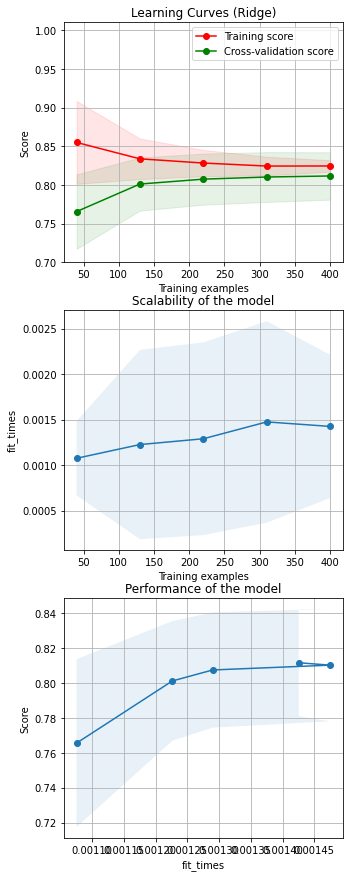

In [ ]:
# plot ridge learning curves

fig, axes = plt.subplots(3, 1, figsize=(5, 15))

title = "Learning Curves (Ridge)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = Ridge()

plot_learning_curve(estimator, title, X, y, axes=axes, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

plt.show()

The results here show that as a model uses larger parts of the dataset, the validation accuracy and training accuracy approach each other. This makes sense because as more data is used the training accuracy will go down, but more learning can take place, thus increasing the validation accuarcy. For the other two graphs, it is clear that this model takes very little time, and as the time increases, so does the score. From looking at these graphs it is clear that this model has a limit for learning. The score is closing in on a value near 0.82. I think that theoretically, this would be the best score achievable with these model parameters. Maybe with an optimized model this score could increase, but overall, it looks like this model has a ceiling. <br><br>

The next algorithm I am going to look at is the SVR.

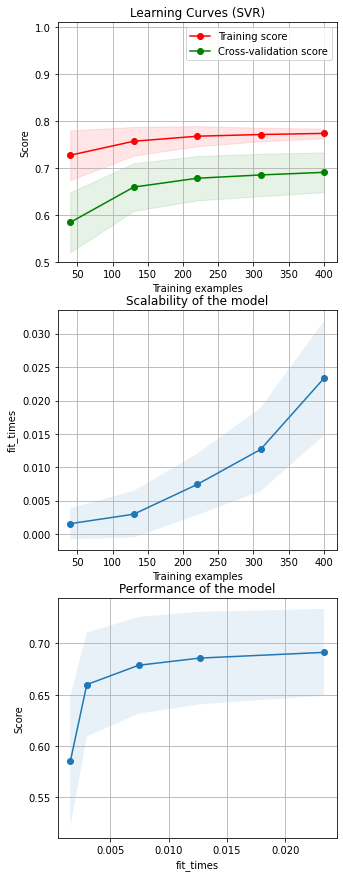

In [ ]:
# plot SVR learning curves

fig, axes = plt.subplots(3, 1, figsize=(5, 15))

title = r"Learning Curves (SVR)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = SVR()
plot_learning_curve(estimator, title, X, y, axes=axes, ylim=(0.5, 1.01), cv=cv, n_jobs=4)

plt.show()

From these learning curves you can again see that as more models are used, the score improves. But this improvement comes with a cost. The time it takes to train an SVR is more than quadradtic, and this is clear in the Scalability of model plot. As more samples are used, the amount of time it takes to train increases. For this dataset this will probably never be too much of an issue, but if the dataset was larger there could be problems that arise from fit times. Compared to the Ridge model, it looks like the maximum achiveable score with the baseline SVR is around 0.7. So far, ridge regression seems to be a better model than the SVR. But maybe the SVR's score could continue to increase if there was more data. <br><br>

The third algorithm I am going to look at learning curves for is the MLP.

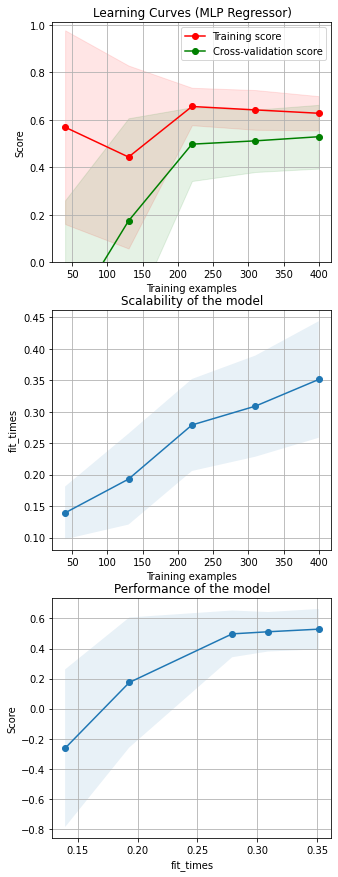

In [ ]:
# plot MLP learning curves

fig, axes = plt.subplots(3, 1, figsize=(5, 15))

title = r"Learning Curves (MLP Regressor)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = MLPRegressor()
plot_learning_curve(estimator, title, X, y, axes=axes, ylim=(0, 1.01), cv=cv, n_jobs=4)

plt.show()

The MLP Regressor might be the worst algorithm of the 5. When given very little data, the performance is useless, and then when using more data, the performance doesn't achieve anything spectacular. The models also takes about 10x longer to train than previous algorithms. Given that the score is lower, and it takes longer to train, it is clear that this algorithm is not the best for this data and problem. There are too many hyper-parameters that need to be optimized in an MLP for the baseline performance to be noteworthy. <br><br>

The fourth algorithm will be random forest.

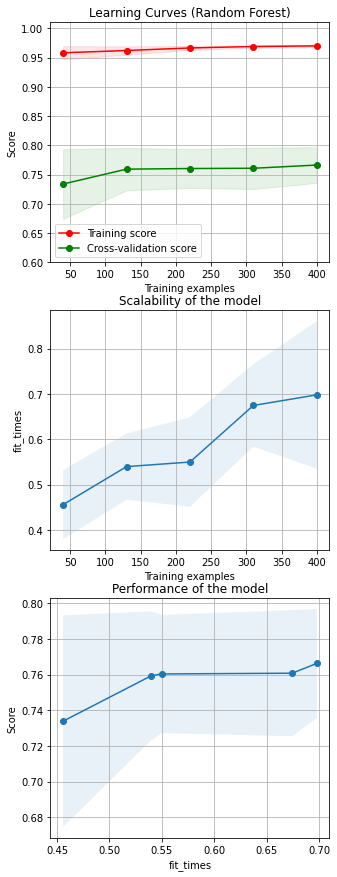

In [ ]:
# plot Random Forest learning curves

fig, axes = plt.subplots(3, 1, figsize=(5, 15))

title = r"Learning Curves (Random Forest)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = RandomForestRegressor()
plot_learning_curve(estimator, title, X, y, axes=axes, ylim=(0.6, 1.01), cv=cv, n_jobs=4)

plt.show()

The performance of the random forest algorithm shows that the training score is nearly perfect, and the validation score is also significant. These scores are comparable to the current best, ridge, but there are a couple distict differences too. First, the performance lines don't seem to converge on a specific score which suggests that the performance could continue to increase with more data samples. The drawback to this, is that the fit times are significantly slower than all previous algorithms. A random forest has to generate many decision trees to achieve higher scores, and as a baseline this random forest has 100 trees. This hyper-parameter could be optimized, and the training times reduced, but the performance might suffer, and the random forest could lose its edge over ridge. Overall, I think that these plots show that the ensemble technique, and random forest, is a powerful technique for this dataset. <br><br>

The final algorithm I am going to look at is KNN.

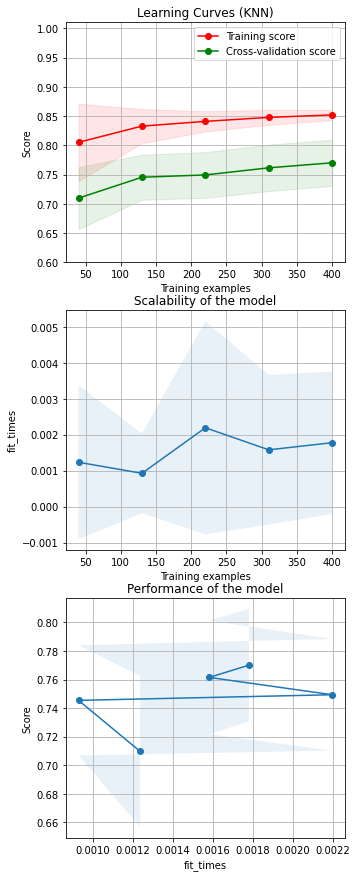

In [ ]:
# plot KNN learning curves

fig, axes = plt.subplots(3, 1, figsize=(5, 15))

title = r"Learning Curves (KNN)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = KNeighborsRegressor()
plot_learning_curve(estimator, title, X, y, axes=axes, ylim=(0.6, 1.01), cv=cv, n_jobs=4)

plt.show()

KNN also appears to be a good model for this data. The performance is comparable to ridge and random forest. Like random forest, the performance doesn't converge, and unlike random forest, the train times are not as extreme. These 3 features - high performance, no performance convergence, and low training times - make it clear that the KNN techinque works very well. I think that given more data the KNN technique could outperform all of the previous algorithms.

For the final part of my project I am going to use sklearn's GridSearch class to perform a grid search of hyper-parameters to optimize each model. In a grid search, parameters of a classifier are given as inputs, and then every possible combination is tested, and the best model parameters can be reported. For this testing I chose some model parameters that I thought were the most important, and then ran the grid search to look at the best models.


In [ ]:
from sklearn.model_selection import GridSearchCV
def run_grid_search(clf, X, y, parameters):
    random_search = GridSearchCV(clf, parameters)
    random_search.fit(X, y)
    report_best_models(random_search.cv_results_)

def report_best_models(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.5f}"
                  .format(results['mean_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [ ]:
# optimize Ridge
params = {
    'alpha': np.linspace(0.001, 100, 100)
}

run_grid_search(Ridge(), X, y, params)

Model with rank: 1
Mean validation score: 0.80864
Parameters: {'alpha': 13.132181818181818}

Model with rank: 2
Mean validation score: 0.80864
Parameters: {'alpha': 14.142272727272728}

Model with rank: 3
Mean validation score: 0.80863
Parameters: {'alpha': 12.12209090909091}



In [ ]:
# optimize SVR 
# **warning** takes a long time

params = {
    'kernel':['rbf', 'linear', 'poly', 'sigmoid'],
    'degree': [2, 3, 4, 5],
    'C': [0.01, 0.1, 1, 10],
    'epsilon': [0.05, 0.1, 0.15, .3, 1]
}

run_grid_search(SVR(), X, y, params)

Model with rank: 1
Mean validation score: 0.81199
Parameters: {'C': 0.01, 'degree': 2, 'epsilon': 0.05, 'kernel': 'linear'}

Model with rank: 1
Mean validation score: 0.81199
Parameters: {'C': 0.01, 'degree': 3, 'epsilon': 0.05, 'kernel': 'linear'}

Model with rank: 1
Mean validation score: 0.81199
Parameters: {'C': 0.01, 'degree': 4, 'epsilon': 0.05, 'kernel': 'linear'}

Model with rank: 1
Mean validation score: 0.81199
Parameters: {'C': 0.01, 'degree': 5, 'epsilon': 0.05, 'kernel': 'linear'}



In [ ]:
# optimize MLPRegressor
# **warning** takes a long time

hidden_layer_sizes=[500, 200, 100, 50, 20, 10]

def powerset(seq):
    if len(seq) <= 0:
        yield []
    else:
        for item in powerset(seq[1:]):
            yield [seq[0]]+item
            yield item

hidden_layer_ps = [p for p in powerset(hidden_layer_sizes)]
hidden_layer_ps.sort()
hidden_layer_ps.pop(0)

params = {
    'hidden_layer_sizes': hidden_layer_ps
}

run_grid_search(MLPRegressor(max_iter=500), X, y, params)

Model with rank: 1
Mean validation score: 0.76887
Parameters: {'hidden_layer_sizes': [500, 200, 100, 50]}

Model with rank: 2
Mean validation score: 0.75687
Parameters: {'hidden_layer_sizes': [200, 100, 50, 10]}

Model with rank: 3
Mean validation score: 0.75561
Parameters: {'hidden_layer_sizes': [500, 200, 100, 50, 20, 10]}



In [ ]:
# Optimize Random Forest
# **warning** takes a long time

params = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 6, 9, None],
    'max_features': [3, 6, 9, 11, None],
    'max_samples': [100, 200, 300, None]
}

run_grid_search(RandomForestRegressor(), X, y, params)

Model with rank: 1
Mean validation score: 0.80653
Parameters: {'max_depth': 9, 'max_features': 6, 'max_samples': 100, 'n_estimators': 100}

Model with rank: 2
Mean validation score: 0.80467
Parameters: {'max_depth': 3, 'max_features': 9, 'max_samples': 100, 'n_estimators': 100}

Model with rank: 3
Mean validation score: 0.80457
Parameters: {'max_depth': 6, 'max_features': 6, 'max_samples': 100, 'n_estimators': 150}



In [ ]:
# Optimize KNN
params = {
    'n_neighbors':[i for i in range(1, 51)],
    'weights': ['uniform', 'distance'],
}

run_grid_search(KNeighborsRegressor(algorithm='kd_tree'), X, y, params)

Model with rank: 1
Mean validation score: 0.78129
Parameters: {'n_neighbors': 27, 'weights': 'distance'}

Model with rank: 2
Mean validation score: 0.78120
Parameters: {'n_neighbors': 28, 'weights': 'distance'}

Model with rank: 3
Mean validation score: 0.78100
Parameters: {'n_neighbors': 24, 'weights': 'distance'}



During each optimizaion, the grid search found different parameters than the baseline parameters, and the scores also increased. The final thing I am going to do for my project is to test each of these optimized models with my five-fold cross validation method, and compare the algorithm results.

In [9]:
# Testing five fold cross validation on optimized estimators - without linear regression
ridge_accuracy = five_fold_cross_val(X, y, Ridge(alpha=13.1322))
svr_accuracy = five_fold_cross_val(X, y, SVR(kernel='linear', C=0.01, epsilon=0.05))
mlp_accuracy = five_fold_cross_val(X, y, MLPRegressor([500, 200, 100, 50], max_iter=500))
rf_accuracy = five_fold_cross_val(X, y, RandomForestRegressor(max_depth=9, max_features=6, max_samples=100, n_estimators=100))
knn_accuracy = five_fold_cross_val(X, y, KNeighborsRegressor(n_neighbors=27, weights='distance'))

print(f"Optimized Ridge Regression Score: {ridge_accuracy}")
print(f"Optimized SVR Score: {svr_accuracy}")
print(f"Optimized MLP Regressor Score: {mlp_accuracy}")
print(f"Optimized Random Forest Score: {rf_accuracy}")
print(f"Optimized KNN Score: {knn_accuracy}")

Baseline Ridge Regression Score: 0.816046741095467
Baseline SVR Score: 0.8124019438300512
Baseline MLP Regressor Score: 0.7866614250156588
Baseline Random Forest Score: 0.8024650801207802
Baseline KNN Score: 0.792556734302365


With the final results, it is clear that there was an improvement over baseline results. Each score increased, and now every score is nearly 0.8. The best algorithm is still ridge, but all of the others are very close.

# Conclusion

In conclusion, all 5 of these algorithms ended up being viable options for regression. The best model appears to be Ridge, but the others, SVR, MLP, Random Forest, and KNN, are close on its heels. From the learning curves, it is clear that ridge seems to have a maximum score, but the others might be able to improve as long as there is more data to use. SVR has long term scaling issues, but for small amounts of data the algorithm is fine. The MLP needs more data to do well, but the hyper-parameters were the main bottle neck, and as soon as those were optimized, the performance dramatically improved. The random forest has high performance, but at the cost of long training times. Finally, KNN has high performance without long training times, but it was never able to achieve an equal score as ridge. <br><br>

Overall, each algorithm has benefits and drawbacks, and it is important to recognize this when doing machine learning tasks. The first model you chose might not always be the best. I think that each algorithm tested could be the one that is used for this problem because each reached nearly the same score at the end. The value of $R^2$ is a measure of how well the outputs are predicted, and also by how much the results are clustered themselves. So there is an absolute limit this value can take. I would guess that 0.8 is close to that limit, and each of these models seems to have gotten close to that level.